In [1]:
from data.gaussian import GaussianDataset
from model import softmax
from plot import plot2d, plot2d_hmap
from metric import recall
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax

In [2]:
dataset = GaussianDataset(N=1000, M=2, D=2)

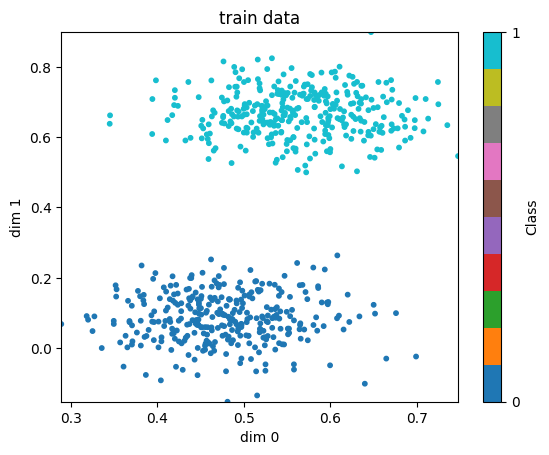

In [3]:
plot2d(dataset.X_train, dataset.Y_train, dataset.get_nclasses(), "train data")

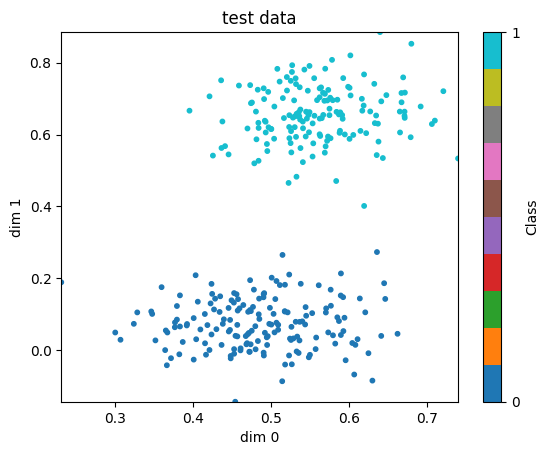

In [4]:
plot2d(dataset.X_test, dataset.Y_test, dataset.get_nclasses(), "test data")

## Bayesian Inference

In [5]:
batchsize = 100000
mu = 0
sigma = 10
D = dataset.X_train.shape[1]

In [6]:
W, b = softmax.sample_theta(
    B = batchsize,
    D = D,
    M = dataset.get_nclasses(),
    mu = mu,
    sigma = sigma
)

y_dist, y_sample = softmax.infer_with_sampled(
    x = dataset.X_test,
    X = dataset.X_train,
    Y = dataset.Y_train,
    W = W,
    b = b
)
dataset.X_test = jax.device_get(dataset.X_test)
dataset.Y_test = jax.device_get(dataset.Y_test)

print(f"y_dist: {y_dist.shape}")
print(f"y_sample: {y_sample.shape}")

y_dist: (330, 2)
y_sample: (330, 100000, 2)


## Result Evaluation
### Recall

In [7]:
r1 = recall(y_dist, dataset.Y_test, r=1)
print(f"Recall@1: {float(r1)}")

/usr/local/lib/python3.8/dist-packages/jax/_src/numpy/lax_numpy.py:3613: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


Recall@1: 99.99999237060547


### Heat map

In [8]:
grain = 50

d0 = np.linspace(np.min(dataset.X_train[:, 0]), np.max(dataset.X_train[:, 0]), grain)
d1 = np.linspace(np.min(dataset.X_train[:, 1]), np.max(dataset.X_train[:, 1]), grain)
d0, d1 = np.meshgrid(d0, d1)

# [grain*grain, 2]
x = np.stack((np.reshape(d0, (grain*grain)), np.reshape(d1, (grain*grain))), axis=1)

In [9]:
y_dist, y_sample = softmax.infer_with_sampled(
    x = x,
    X = dataset.X_train,
    Y = dataset.Y_train,
    W = W,
    b = b
)
# [grain, grain, n_cls]
y_dist = np.reshape(y_dist, (grain, grain, y_dist.shape[1]))
# [grain, grain, B, n_cls]
y_sample = np.reshape(y_sample, (grain, grain, y_sample.shape[1], y_sample.shape[2]))

### Heat map of mean

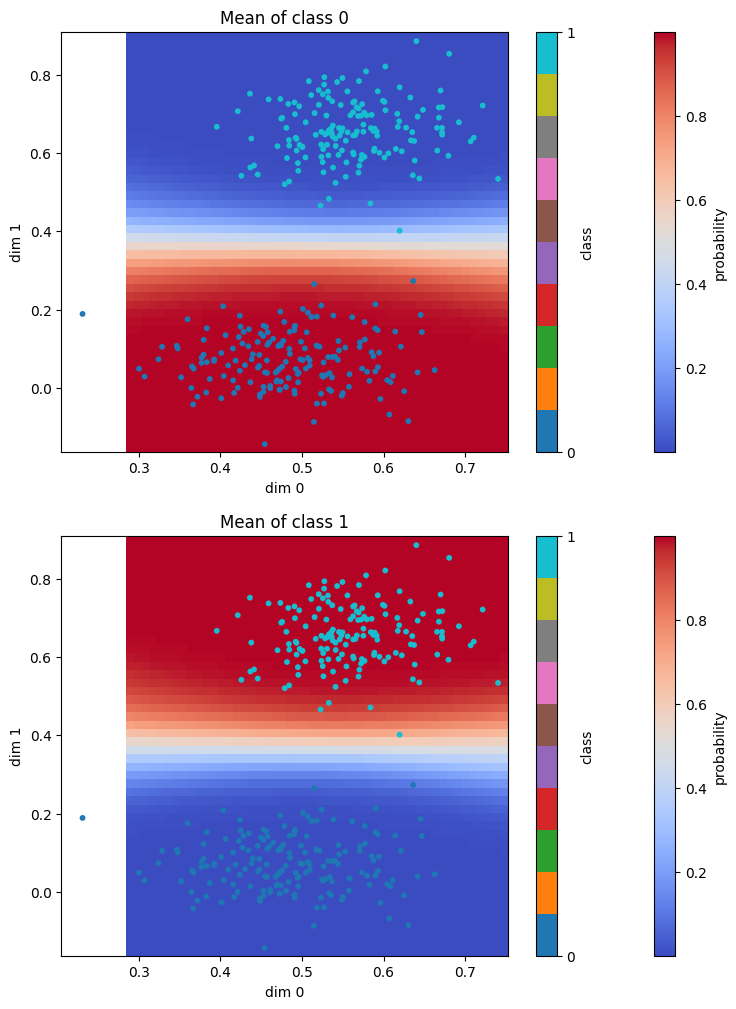

In [20]:
_, axs = plt.subplots(dataset.get_nclasses(), 1, figsize=(9,6*dataset.get_nclasses()))
for c in range(dataset.get_nclasses()):
    # heat map
    mesh = axs[c].pcolormesh(d0, d1, y_dist[:, :, c], cmap='coolwarm')
    mesh_cbar = plt.colorbar(mesh)
    mesh_cbar.set_label("probability")

    axs[c].set_xlabel('dim 0')
    axs[c].set_ylabel('dim 1')
    axs[c].set_title(f"Mean of class {c}")

    cmap = plt.get_cmap('tab10')
    scatter = axs[c].scatter(dataset.X_test[:, 0], dataset.X_test[:, 1], c=dataset.Y_test, cmap=cmap, label=dataset.Y_test, s=10)
    cbar = plt.colorbar(scatter)
    cbar.set_ticks(np.arange(dataset.get_nclasses()))
    cbar.set_label("class")
    

plt.show()

### Heat map of variance

In [11]:
y_var = jnp.var(y_sample, axis=2)

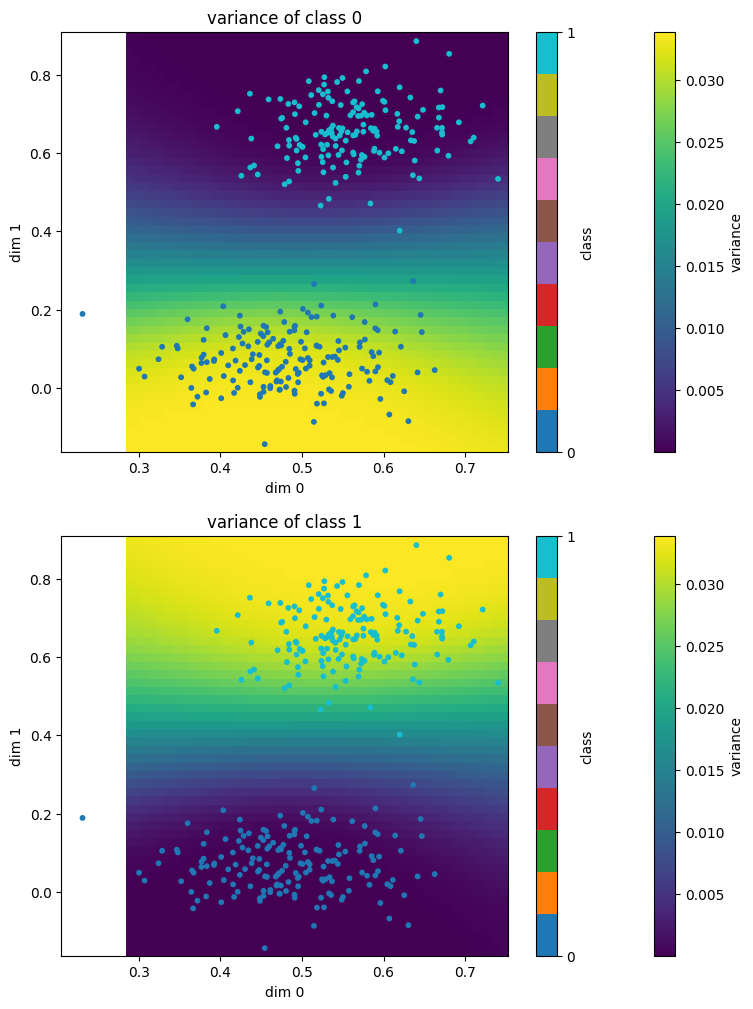

In [19]:
_, axs = plt.subplots(dataset.get_nclasses(), 1, figsize=(9,6*dataset.get_nclasses()))
for c in range(dataset.get_nclasses()):
    # heat map
    mesh = axs[c].pcolormesh(d0, d1, y_var[:, :, c], cmap='viridis')
    mesh_cbar = plt.colorbar(mesh)
    mesh_cbar.set_label("variance")

    axs[c].set_xlabel('dim 0')
    axs[c].set_ylabel('dim 1')
    axs[c].set_title(f"variance of class {c}")

    cmap = plt.get_cmap('tab10')
    scatter = axs[c].scatter(dataset.X_test[:, 0], dataset.X_test[:, 1], c=dataset.Y_test, cmap=cmap, label=dataset.Y_test, s=10)
    cbar = plt.colorbar(scatter)
    cbar.set_ticks(np.arange(dataset.get_nclasses()))
    cbar.set_label("class")
    

plt.show()